# main
%run で呼び出さないやり方
- main関数でconfig.pyを読み込み。
- StarGANのpyファイルは同じフォルダに必要

In [1]:
# StarGAN

import os
from torch.backends import cudnn

from solver import Solver
from data_loader import get_loader
import config

def main(config):
    # For fast training.
    cudnn.benchmark = True

    # Create directories if not exist.
    if not os.path.exists(config.log_dir):
        os.makedirs(config.log_dir)
    if not os.path.exists(config.model_save_dir):
        os.makedirs(config.model_save_dir)
    if not os.path.exists(config.sample_dir):
        os.makedirs(config.sample_dir)
    if not os.path.exists(config.result_dir):
        os.makedirs(config.result_dir)

    # Data loader.
    celeba_loader = None
    rafd_loader = None

    if config.dataset in ['CelebA', 'Both']:
        celeba_loader = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
                                   config.celeba_crop_size, config.image_size, config.batch_size,
                                   'CelebA', config.mode, config.num_workers)
    if config.dataset in ['RaFD', 'Both']:
        rafd_loader = get_loader(config.rafd_image_dir, None, None,
                                 config.rafd_crop_size, config.image_size, config.batch_size,
                                 'RaFD', config.mode, config.num_workers)
    

    # Solver for training and testing StarGAN.
    solver = Solver(celeba_loader, rafd_loader, config)

    if config.mode == 'train':
        if config.dataset in ['CelebA', 'RaFD']:
            solver.train()
        elif config.dataset in ['Both']:
            solver.train_multi()
    elif config.mode == 'test':
        if config.dataset in ['CelebA', 'RaFD']:
            solver.test()
        elif config.dataset in ['Both']:
            solver.test_multi()

Generator(
  (main): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

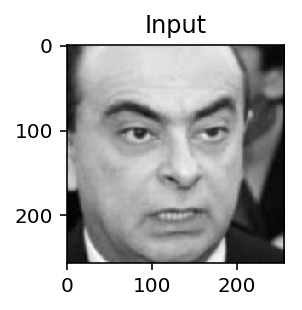

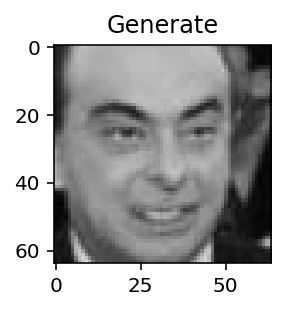

In [4]:
#################
#   テキスト ⇒ 画像生成    #
#################

####テキスト→感情####

import time
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle
from PIL import Image

t1 = time.time() 

MAX_SEQUENCE_LENGTH = 30 # max length of text (words) including padding

with open('src/tec/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
classes = ["neutral", "happy", "sad", "hate","anger"]
    
##入力##    
text = ['Very good!!']
# text = ['Is not it useless?','very good!!', "I don't feel well today.", "A triplet was born."]
img_path = "inp/test/neu/Carlos_Ghosn_0002.jpg"

model = load_model('models/txt2emo/checkpoint-0.923.h5')

sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
pred = y_prob.argmax(axis=-1)[0]

t2 = time.time() 

####感情→画像####
# %run -i src/stg/main.py --mode test --dataset RaFD --rafd_crop_size 256 --image_size 64 --c_dim 3 --selected_attrs neg neu pos --rafd_image_dir inp/test --model_save_dir models/emo2Img --result_dir res
main(config)    # replace by H.K.

####結果表示####
print('')
print("％％％％％％結果％％％％％％")
print("入力文：", text[0],"-->感情推定結果：",classes[pred],"\n")

from PIL import Image
import matplotlib.pyplot as plt

# 元画像
img_inp = Image.open(img_path)
plt.figure(figsize=(3, 2)) # figureの縦横の大きさ
plt.title("Input")
plt.imshow(np.array(img_inp), 'gray')

# 出力画像
img_oup = Image.open("res/1-images.jpg")
imga = np.array(img_oup)
imsize = 64

plt.figure(figsize=(3, 2)) # figureの縦横の大きさ
plt.title("Generate")

if pred == 0: # neutral
    st = imsize*2
    plt.imshow(imga[:, st:st+imsize])
elif pred == 1: # happy
    st = imsize*3
    plt.imshow(imga[:, st:st+imsize])
else: # sad, hate, anger
    st = imsize
    plt.imshow(imga[:, st:st+imsize])
    
t3 = time.time() 
t_t2e = t2-t1
t_e2i = t3-t2
t_tot = t3-t1

print(f"経過時間(text⇒emo)：{t_t2e}")
print(f"経過時間(emo⇒img)：{t_e2i}")
print(f"経過時間(total)：{t_tot}")


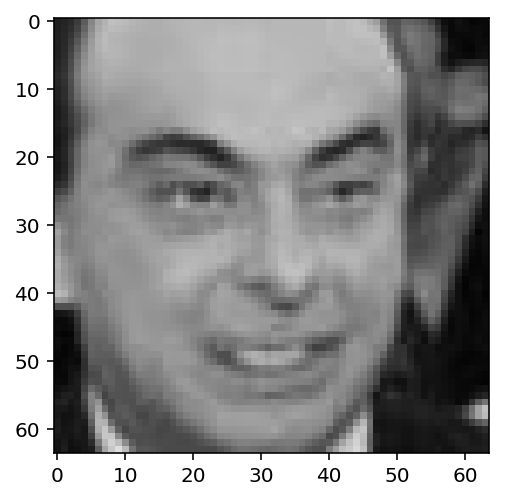

In [3]:
plt.imshow(imga[:, st:st+imsize])